<a href="https://colab.research.google.com/github/RayGone/SentimentAnalysis/blob/main/Experiments/BERT_Embedding_As_Feature/SA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
!pip install transformers tokenizers datasets -q

In [36]:
import numpy as np
import random
import os
import tensorflow as tf
from transformers import set_seed

rand_seed = 9

def seed_everything(seed=0):
    random.seed(seed) # random
    os.environ['PYTHONHASHSEED'] = str(seed) # python enviroment
    np.random.seed(seed) # numpy
    tf.keras.utils.set_random_seed(seed) # tensorflow
    tf.random.set_seed(seed) # tensorflow
    set_seed(seed) # hugging_face transformer

seed_everything(rand_seed)

In [37]:
import datasets

data = datasets.load_dataset("raygx/NepCov19TweetsPlus").rename_columns({"Sentiment":"label","Sentences":"text"}).shuffle(999)['train'].train_test_split(test_size=0.2)
data


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 33232
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 8309
    })
})

In [38]:
def LabelEncoding(x):
    if x['label']==-1:
        x['label'] =  2
    return x

data = data.map(
        LabelEncoding,
        num_proc=2)

data['train'][:5]

{'label': [0, 0, 0, 0, 1],
 'text': ['बालबालिकामा कोभिड का लक्षण देखिएमा के गर्ने सफल नेपाल',
  'कोविड र सामान्य चिसोमा के गर्ने र नगर्ने बीच कसरी फरक गर्ने',
  'बैठकमा मिलेनियम च्यालेन्ज कर्पोरेशन एमसीसीको बजेट र कोभिडबारे पनि छलफल हुने अर्का स्थायी समिति सदस्य देवेन्द्र पौडेलले जानकारी दिए ।',
  'कोभिड –१९ महामारीले नेपालमा बालबालिकाको स्वास्थ्य, सिकाइ र मनोसामाजिक अवस्थालाई असर पारेको\u200d युनिसेफकाे एक अध्ययनले देखाएको छ\xa0। \u200d',
  'डब्लूएचओको प्रत्यक्ष निगरानीमा कोरोना परीक्षण कोभिड यसकारण भित्रिएको छैन नेपालमा']}

In [40]:
from transformers import TFBertForSequenceClassification, BertTokenizerFast

model_id = 'raygx/BERT-NepSA-T2' ## Fine-tuned Model for SA ## 'raygx/BertClassifier4NepaliNews' ## Fine-tuned Model for NewsClassification ## 'Shushant/nepaliBERT' ## Pre-Trained LM ##

tokenizer = BertTokenizerFast.from_pretrained(model_id)
tokenizer

try:
  model = TFBertForSequenceClassification.from_pretrained(model_id,
              id2label={0:"NEUTRAL",1:"POSITIVE",2:"NEGATIVE"},
              label2id={"NEUTRAL":0,"POSITIVE":1,"NEGATIVE":2},ignore_mismatched_sizes=True)
except:
  model = TFBertForSequenceClassification.from_pretrained(model_id,
              id2label={0:"NEUTRAL",1:"POSITIVE",2:"NEGATIVE"},
              label2id={"NEUTRAL":0,"POSITIVE":1,"NEGATIVE":2},ignore_mismatched_sizes=True,from_pt=True)

model.summary()

Some layers from the model checkpoint at raygx/BERT-NepSA-T2 were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at raygx/BERT-NepSA-T2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_77 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
Total params: 109,484,547
Trainable params: 109,484,547
Non-trainable params: 0
_________________________________________________________________


### Code For Using BERT as Embedding Layer

In [41]:
import tensorflow as tf

class BERTEmbedding(tf.keras.layers.Layer):
  def __init__(self, model,tokenizer, max_token_len=128,padding='max_length',truncation=True):
    super().__init__()
    self.embedding = model
    self.tokenizer = tokenizer
    self.max_token = max_token_len
    self.padding = padding
    self.truncation = truncation
    self.trainable=False

  def call(self, x):
    # if x.shape[0] != None:
    #   x = [str(i) for i in x]
    # else:
    #   x = str(x)
    return self.embedding(self.tokenizer(x,padding=self.padding,truncation=self.truncation,max_length=self.max_token,return_tensors='tf'))[1]

In [42]:
# model.bert(tokenizer('बैंक तथा वित्तीय संस्थामा देखिएको विश्वासको',padding='max_length',truncation=True,return_tensors='tf',max_length=128))
embd = BERTEmbedding(model.bert,tokenizer,max_token_len=100)
# embd(["",'बैंक तथा वित्तीय संस्थामा देखिएको विश्वासको','बैंक तथा वित्तीय संस्थामा देखिएको विश्वासको'])
# embd(["abcd"])
d_model = embd(["abcd",'efgh']).shape[1]
d_model

768

In [43]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data,model_dim, batch_size=32,shuffle=True):
        'Initialization'
        self.batch_size = batch_size
        self.data = data
        self.embeddings = np.empty((data.num_rows,model_dim))
        self.shuffle = shuffle
        # self.average = tf.keras.layers.Average()
        self.is_first_epoch = True
        self.on_epoch_end(is_first_epoch=self.is_first_epoch)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(self.data.num_rows / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        return self.__data_generation(indexes)

    def on_epoch_end(self,is_first_epoch=False):
        'Updates indexes after each epoch'
        self.indexes = np.arange(self.data.num_rows)
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

        self.is_first_epoch = is_first_epoch


    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        chunk = self.data.select(indexes)

        if self.is_first_epoch:
          X = embd(chunk['text'])
          self.embeddings[indexes] = X
        else:
          X = self.embeddings[indexes]

        y = np.array(chunk['label'])
        return X,y

In [44]:
%%time

train_features = DataGenerator(data['train'],model_dim=d_model,batch_size=16)
test_features = DataGenerator(data['test'],model_dim=d_model,shuffle=False)

CPU times: user 910 µs, sys: 0 ns, total: 910 µs
Wall time: 921 µs


## Model Specification

In [45]:
sa_model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(768)),
    tf.keras.layers.Dense(256,activation='relu',name='Dense'),
    tf.keras.layers.Dropout(0.1,name='Dropout'),
    tf.keras.layers.Dense(3,activation='softmax',name='Activation')
])

In [46]:
sa_model.compile(
  optimizer=tf.keras.optimizers.Adam(
        learning_rate=5e-5,
        weight_decay=0.001
      ),
  loss='sparse_categorical_crossentropy',
  metrics=['acc'])

sa_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense (Dense)               (None, 256)               196864    
                                                                 
 Dropout (Dropout)           (None, 256)               0         
                                                                 
 Activation (Dense)          (None, 3)                 771       
                                                                 
Total params: 197,635
Trainable params: 197,635
Non-trainable params: 0
_________________________________________________________________


In [47]:
history = sa_model.fit(train_features,
        epochs=30,
        validation_data=test_features,
        callbacks=[tf.keras.callbacks.EarlyStopping(
                            monitor='val_acc', patience=3,
                            verbose=1, mode='max',
                            restore_best_weights=True)
                        ])

Epoch 1/30
2077/2077 [==============================] - 540s 259ms/step - loss: 0.6472 - acc: 0.7253 - val_loss: 0.6136 - val_acc: 0.7429
Epoch 2/30
2077/2077 [==============================] - 14s 7ms/step - loss: 0.5942 - acc: 0.7524 - val_loss: 0.5954 - val_acc: 0.7502
Epoch 3/30
2077/2077 [==============================] - 14s 7ms/step - loss: 0.5743 - acc: 0.7631 - val_loss: 0.5828 - val_acc: 0.7569
Epoch 4/30
2077/2077 [==============================] - 14s 7ms/step - loss: 0.5633 - acc: 0.7677 - val_loss: 0.5758 - val_acc: 0.7592
Epoch 5/30
2077/2077 [==============================] - 14s 7ms/step - loss: 0.5532 - acc: 0.7749 - val_loss: 0.5696 - val_acc: 0.7604
Epoch 6/30
2077/2077 [==============================] - 14s 7ms/step - loss: 0.5440 - acc: 0.7762 - val_loss: 0.5678 - val_acc: 0.7640
Epoch 7/30
2077/2077 [==============================] - 14s 7ms/step - loss: 0.5372 - acc: 0.7789 - val_loss: 0.5638 - val_acc: 0.7657
Epoch 8/30
2077/2077 [==============================

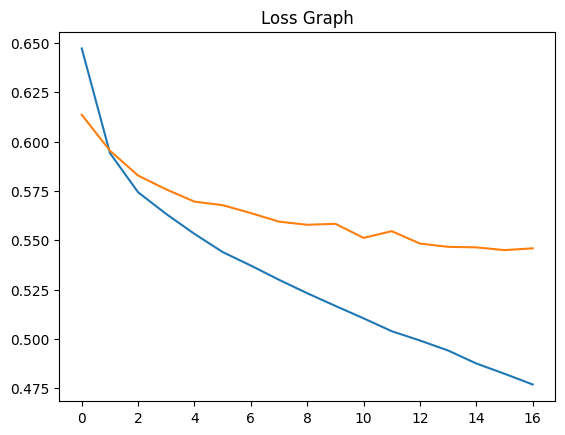

Text(0.5, 1.0, 'Accuracy Graph')

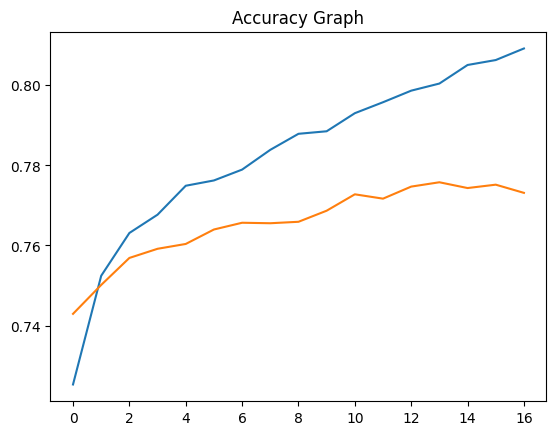

In [48]:
import seaborn
from matplotlib import pyplot as plt

seaborn.lineplot(history.history['loss'])
seaborn.lineplot(history.history['val_loss'])
plt.title("Loss Graph")
plt.show()

seaborn.lineplot(history.history['acc'])
seaborn.lineplot(history.history['val_acc'])
plt.title("Accuracy Graph")

## Evaluation Section

In [49]:
%%time

print("Getting Test Prediction")
pred_labels = [np.argmax(x) for x in sa_model.predict(test_features)]
actual_labels = data['test']['label']

Getting Test Prediction
260/260 [==============================] - 1s 5ms/step
CPU times: user 1.48 s, sys: 52 ms, total: 1.53 s
Wall time: 2.65 s


In [50]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

print("F1-Score",f1_score(actual_labels,pred_labels,average='weighted'))
print("Precision-Score",precision_score(actual_labels,pred_labels,average='weighted'))
print("Recall-Score",recall_score(actual_labels,pred_labels,average='weighted'))
print("accuracy_Score",accuracy_score(actual_labels,pred_labels))

F1-Score 0.7755690110910818
Precision-Score 0.7756264977533763
Recall-Score 0.7757852930557227
accuracy_Score 0.7757852930557227


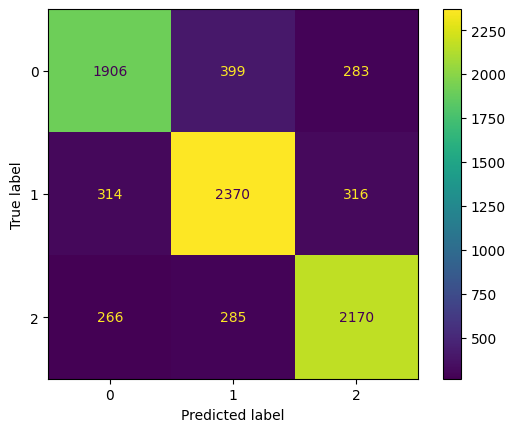

In [51]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cmd = ConfusionMatrixDisplay(tf.math.confusion_matrix(actual_labels,pred_labels,num_classes=3).numpy())
cmd.plot()